## Import Package

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [8, 6]

## Load & Check Data

In [4]:
data = pd.DataFrame({
    
    'weeks':[36, 38, 39, 41, 37, 38, 40, 40, 38, 41, 38, 38, 40, 40, 36, 39, 40,
       35, 39, 38, 37, 43, 39, 39, 40, 40, 37, 38, 39, 38, 40, 40, 42, 37,
       41, 38, 37, 39, 40, 40, 38, 41, 38, 37, 39, 39, 43, 38, 38, 38],
    
    'weight':[2980, 2707, 3049, 3429, 2500, 2845, 3071, 3435, 3058, 3123, 3215,
       2902, 3015, 2983, 2727, 3121, 3114, 2511, 3327, 2864, 2749, 3621,
       2860, 3074, 3234, 3083, 2797, 3025, 3129, 2990, 3035, 2990, 3513,
       2687, 3380, 2863, 2715, 3012, 3083, 2938, 2837, 3455, 3175, 2646,
       2889, 2975, 3474, 3052, 3167, 2762],
    
    'gender':[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1]
})

In [5]:
data.head(10)

,weeks,weight,gender
0,36,2980,0
1,38,2707,1
2,39,3049,1
3,41,3429,1
4,37,2500,1
5,38,2845,1
6,40,3071,0
7,40,3435,0
8,38,3058,0
9,41,3123,1


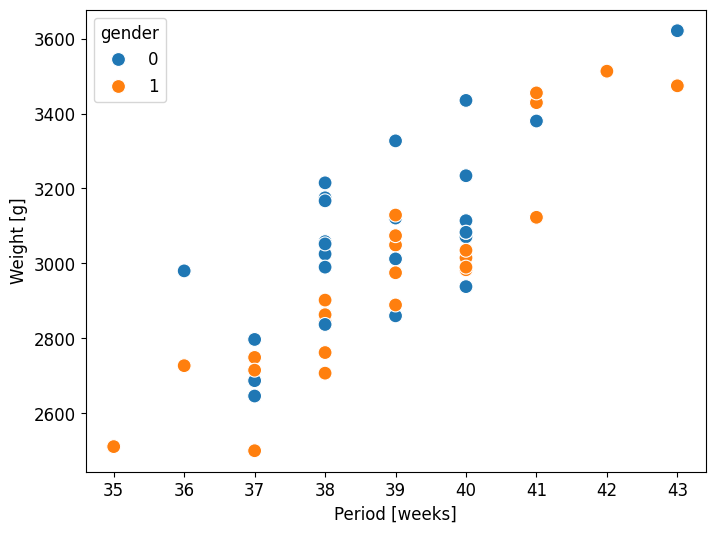

In [6]:
sns.scatterplot(data=data, x='weeks', y='weight', hue='gender', s=100)

plt.xlabel('Period [weeks]')
plt.ylabel('Weight [g]');

## Preprocess & Scale Data

In [7]:
x = data['weeks'].values
y = data['weight'].values

In [8]:

x_mu = np.mean(x)
x_sd = np.std(x)

x_scaled = (x - x_mu) / x_sd

y_mu = np.mean(y)
y_sd = np.std(y)

y_scaled = (y - y_mu) / y_sd

## Define Model & Inference

In [9]:
def model(x_scaled=None, y_scaled=None, num_data=0):
    
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))
    
    mu = a * x_scaled + b
    
    sd = numpyro.sample('sd', dist.HalfCauchy(5))
    
    with numpyro.plate('data', num_data):
                
        numpyro.sample('obs', dist.Normal(mu, sd), obs=y_scaled)
        

In [10]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x_scaled=x_scaled, y_scaled=y_scaled, num_data=len(y_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

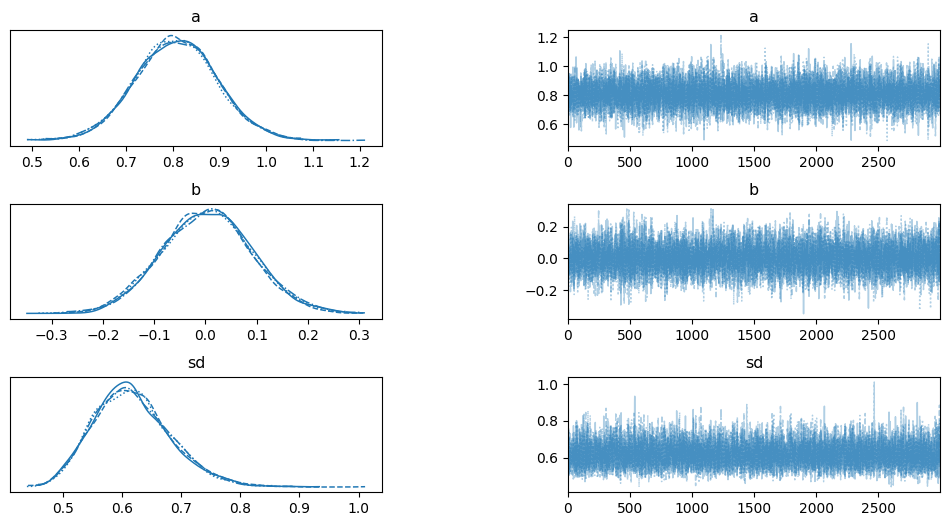

In [12]:
az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.808,0.087,0.640,0.971,0.001,0.001,12193.0,8572.0,1.0
b,0.003,0.088,-0.160,0.172,0.001,0.001,9689.0,7954.0,1.0
sd,0.618,0.065,0.501,0.741,0.001,0.001,10193.0,8269.0,1.0


## Check MCMC-samples

In [14]:
def plot_lines(trace):
    
    samples_to_plot = 50

    x_scaled_new = np.linspace(-3, 3, 50)
        
    for k in range(1, samples_to_plot):
        
        a_sample = trace['a'][-k]
        b_sample = trace['b'][-k]
    
        mu = a_sample * x_scaled_new + b_sample
        
        plt.plot(x_scaled_new, mu, c='g', alpha=0.1)
    

In [15]:
mcmc_samples['b'].shape

(12000,)

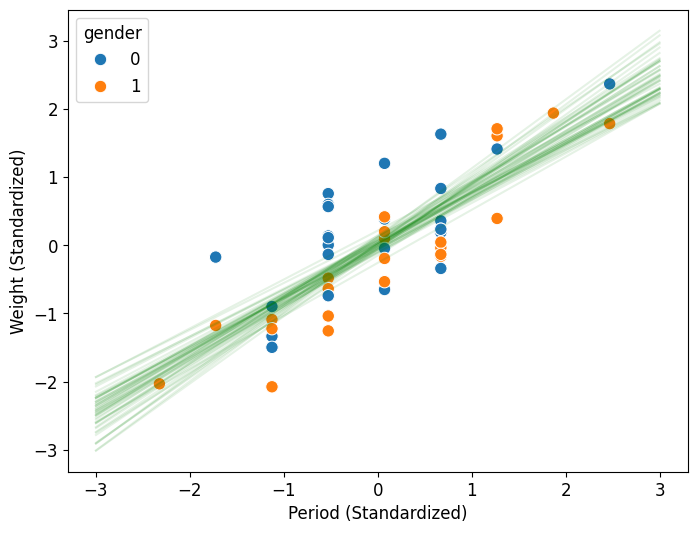

In [16]:
plot_lines(mcmc_samples)

sns.scatterplot(x=x_scaled, y=y_scaled, hue=data['gender'], s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)');

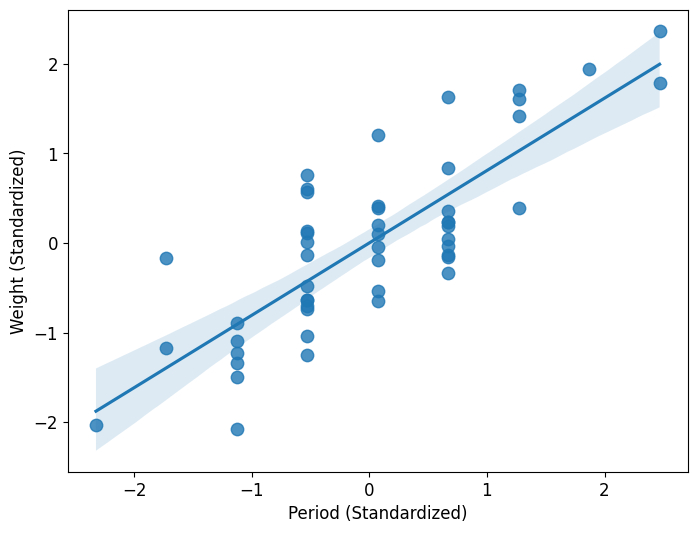

In [17]:
sns.regplot(x=x_scaled, y=y_scaled, scatter_kws={'s':80})

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)');

## Posterior Predictive Check

In [18]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), x_scaled=x_scaled, num_data=len(y_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

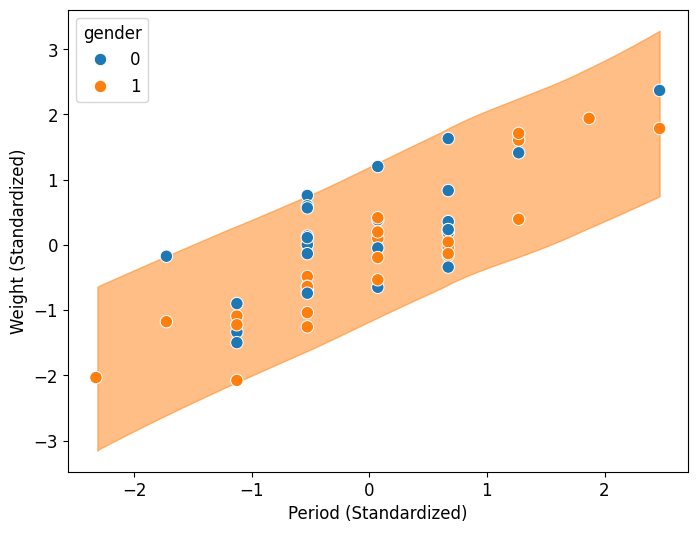

In [19]:
az.plot_hdi(x_scaled, idata_ppc.posterior_predictive['obs'])

sns.scatterplot(x=x_scaled, y=y_scaled, hue=data['gender'], s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)');